In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot


# import external modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
from matplotlib import rc
import pandas as pd
import importlib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

rc('font',**{'family':'serif'})
rc('text', usetex=True)

np.random.seed(4)

In [35]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A = Masses['A'].to_numpy()
Z = Masses['Z'].to_numpy()
N = Masses['N'].to_numpy()
Element = Masses['Element'].to_numpy()
Energies = Masses['Ebinding'].to_numpy()

#Energies_unc = Masses['E_unc'].to_numpy()
Energies_unc = Masses['E_unc'].to_numpy()

In [36]:
ndim = 6

In [37]:
# define parameter space


theta_0_bound = np.array([4, 5]).reshape(1,-1)
theta_1_bound = np.array([-0.25, -0.15]).reshape(1,-1)
theta_2_bound = np.array([0.8, 1.1]).reshape(1,-1)
theta_3_bound = np.array([0.006, 0.009]).reshape(1,-1) # keep
theta_4_bound = np.array([0.25, 0.4]).reshape(1,-1)
theta_5_bound = np.array([-0.1, 0.1]).reshape(1,-1)


parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound, theta_5_bound), axis=0)

#parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)



theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_3_vals = np.linspace(parameter_bounds[3,0], parameter_bounds[3,1], 100)
theta_4_vals = np.linspace(parameter_bounds[4,0], parameter_bounds[4,1], 100)
theta_5_vals = np.linspace(parameter_bounds[5,0], parameter_bounds[5,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1), theta_3_vals.reshape(1,-1), theta_4_vals.reshape(1,-1), theta_5_vals.reshape(1,-1)), axis=0)


In [38]:
def LiquidDropModel(a0, a1, a2, a3, a4, a5, A, Z, N):
    
    return a0 + a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
                + a4*((N-Z)**2)/A + a5*( (-1)**Z + (-1)**N )*(2*A**(-0.5))

In [39]:

# design matrix X
X = np.zeros((len(A),6))
X[:,0] = np.ones_like(A)
X[:,1] = A
X[:,2] = A**(2.0/3.0)
X[:,3] = Z*(Z-1) * A**(-1.0/3.0)
X[:,4] = (N-Z)**2 * A**(-1.0)
X[:,5] = ( (-1)**Z + (-1)**N )*(2*A**(-0.5))


In [40]:
clf = skl.LinearRegression(fit_intercept=False).fit(X, Energies)

print(clf.coef_)

preds = clf.predict(X)

err = np.sum(np.square(Energies-preds))

print(err)

#pred_sigma = np.sqrt(np.var(err))
pred_sigma = np.sqrt(err / (len(Energies) - ndim - 1))

print(pred_sigma)


[ 4.73627103 -0.20205821  0.94821898  0.00784371  0.3234039   0.01146729]
1.552893362984103
0.07865638020750143


In [41]:
# ***** mean of unc?? corresponds to each output ***********
variance = np.mean(Energies_unc)**2 + pred_sigma**2
print(variance)

0.006186826284545569


In [42]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

In [43]:
A1 = A_matrix(X, variance)
b1 = Energies / np.sqrt(variance)

In [44]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

In [45]:
theta = solve_theta(A1, b1)
print(theta)

[ 4.73627103 -0.20205821  0.94821898  0.00784371  0.3234039   0.01146729]


In [46]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

In [47]:
H1 = H_matrix(A1)
cov_matrix = covariance(X, variance)

In [48]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * np.sqrt(5.991) * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)
    #ax.plot(Ell_rot[:,0], Ell_rot[:,1])

In [49]:
def plot_ellipses(fig, parameter_bounds, true_parameters, H, theta_best, theta_vals, color):
    theta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{A}$', r'$a_{P}$']
    N = len(theta_best)
    for i in range(N):
        for j in range(N):
            ax = fig.axes[i + N*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                ax_right = ax.twinx()
                ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
                if i == 3:
                    ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 3)) + r'$\pm$' + \
                                   str(round(np.sqrt(H[i,i]),4)), fontsize=14)
                else:
                    ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 3)) + r'$\pm$' + \
                                       str(round(np.sqrt(H[i,i]),3)), fontsize=14)
                
            elif i < j:
                
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                ax.set_ylabel(theta_names[j])
                ax.set_xlabel(theta_names[i])
                #ax.set_xlim([parameter_bounds[i,0], parameter_bounds[i,1]])
                #zax.set_ylim([parameter_bounds[j,0], parameter_bounds[j,1]])
                
            else:
                ax.axis('off')
                
    plt.tight_layout()

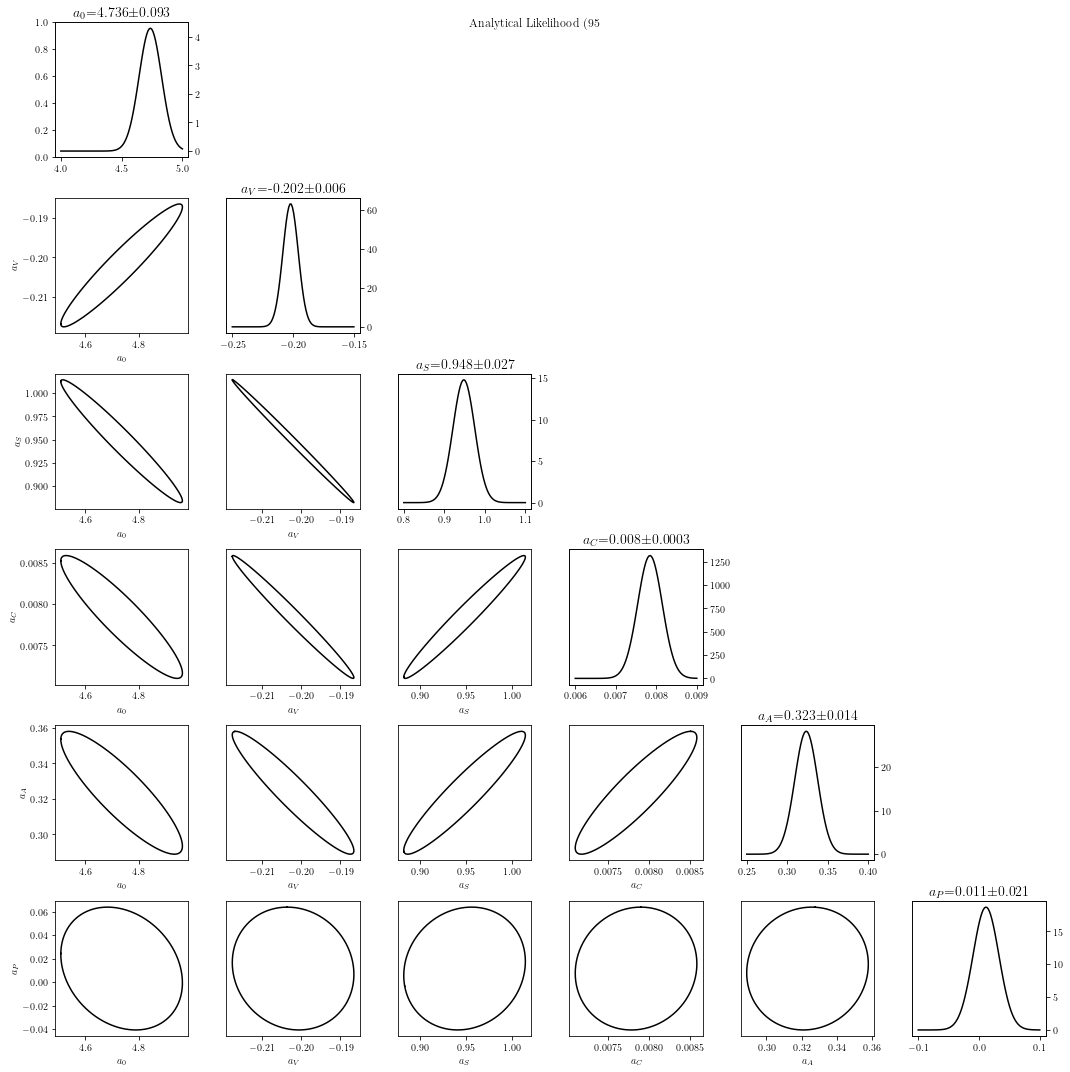

In [50]:
color_list = ['black', 'plum', 'mediumaquamarine', 'red']
N = ndim
fig, axes = plt.subplots(N,N,figsize=(15,15))

plot_ellipses(fig, parameter_bounds, theta, H1, theta, theta_vals, color_list[0])
fig.suptitle(r'Analytical Likelihood (95% Isoprobability Surface)')
plt.savefig('figures/LD_analytical.png', bbox_inches='tight', facecolor='white', transparent=False)

In [51]:
file2 = open("data/LD_analytic_mean.txt", "w")

np.savetxt(file2, theta)
    
file2.close()

file1 = open("data/LD_analytic_cov.txt", "w")

for i in range(H1.shape[0]):
    np.savetxt(file1, H1[i])
    
file1.close()

print(H1)

[[ 8.61171315e-03  5.58357491e-04 -2.42517509e-03 -2.57067090e-05
  -1.13966281e-03 -4.59983593e-04]
 [ 5.58357491e-04  4.00928893e-05 -1.70200792e-04 -1.89512283e-06
  -8.44780749e-05 -1.29033141e-05]
 [-2.42517509e-03 -1.70200792e-04  7.26723227e-04  7.97900139e-06
   3.56676361e-04  6.60627878e-05]
 [-2.57067090e-05 -1.89512283e-06  7.97900139e-06  9.20913701e-08
   3.85335751e-06  5.02549553e-07]
 [-1.13966281e-03 -8.44780749e-05  3.56676361e-04  3.85335751e-06
   2.00232952e-04  2.13818087e-05]
 [-4.59983593e-04 -1.29033141e-05  6.60627878e-05  5.02549553e-07
   2.13818087e-05  4.56059769e-04]]
